<a href="https://colab.research.google.com/github/LinkedInLearning/introduction-to-generative-adversarial-networks-gans-3963173/blob/main/03_03_end.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GAN Lab: Generating Synthetic Customer Reviews with Keras

This lab is part of your **Introduction to GANs** course. You'll build a simple Generative Adversarial Network (GAN) to generate structured synthetic data similar to customer reviews. The lab includes:

- Building the Generator and Discriminator in Keras
- Training the GAN
- Plotting smoothed loss curves
- Visualizing real vs. synthetic data
- Showing model convergence

In [ ]:

# 📦 Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from scipy.ndimage import gaussian_filter1d
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers

# 🧪 Reproducibility
np.random.seed(42)
tf.random.set_seed(42)


In [ ]:

# 📊 Step 1: Simulate structured customer review data
n_samples = 3000
ratings = np.random.randint(1, 6, size=n_samples)
review_length = np.random.normal(loc=50, scale=10, size=n_samples)
sentiment_score = np.random.normal(loc=0.5, scale=0.15, size=n_samples)

df = pd.DataFrame({
    'rating': ratings,
    'review_length': review_length,
    'sentiment_score': sentiment_score
})

# Normalize the data for GAN input/output compatibility
scaler = MinMaxScaler()
X = scaler.fit_transform(df)
input_dim = X.shape[1]
latent_dim = 32


In [ ]:

# 🛠️ Step 2: Define the Generator
def build_generator():
    model = models.Sequential([
        layers.Input(shape=(latent_dim,)),
        layers.Dense(64),
        layers.LeakyReLU(0.2),
        layers.BatchNormalization(),
        layers.Dense(128),
        layers.LeakyReLU(0.2),
        layers.BatchNormalization(),
        layers.Dense(input_dim, activation='sigmoid')  # match [0, 1] scaling
    ])
    return model


In [ ]:

# 🧠 Step 3: Define the Discriminator
def build_discriminator():
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(128),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),
        layers.Dense(64),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')  # output probability real/fake
    ])
    return model


In [ ]:

# ⚙️ Step 4: Instantiate and compile the models
generator = build_generator()
discriminator = build_discriminator()
discriminator.compile(optimizer=optimizers.Adam(0.0002, 0.5), loss='binary_crossentropy')

# Combined model
discriminator.trainable = False
z = layers.Input(shape=(latent_dim,))
generated = generator(z)
validity = discriminator(generated)
gan = models.Model(z, validity)
gan.compile(optimizer=optimizers.Adam(0.0002, 0.5), loss='binary_crossentropy')


In [ ]:

# 🚀 Step 5: Train the GAN
epochs = 1000
batch_size = 64
d_losses, g_losses = [], []
real = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

for epoch in range(epochs):
    # Real samples
    idx = np.random.randint(0, X.shape[0], batch_size)
    real_data = X[idx]

    # Fake samples
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    fake_data = generator.predict(noise, verbose=0)

    # Train Discriminator
    X_combined = np.vstack([real_data, fake_data])
    y_combined = np.concatenate([real, fake])
    discriminator.trainable = True
    d_loss = discriminator.train_on_batch(X_combined, y_combined)

    # Train Generator
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    y_gen = np.ones((batch_size, 1))  # generator wants these to be seen as real
    discriminator.trainable = False
    g_loss = gan.train_on_batch(noise, y_gen)

    d_losses.append(d_loss)
    g_losses.append(g_loss)

    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch+1}/{epochs} | D Loss: {d_loss:.4f} | G Loss: {g_loss:.4f}")


Epoch 100/1000 | D Loss: 0.6892 | G Loss: 0.6826
Epoch 200/1000 | D Loss: 0.6915 | G Loss: 0.6894
Epoch 300/1000 | D Loss: 0.6920 | G Loss: 0.6948
Epoch 400/1000 | D Loss: 0.6926 | G Loss: 0.6954
Epoch 500/1000 | D Loss: 0.6929 | G Loss: 0.6955
Epoch 600/1000 | D Loss: 0.6931 | G Loss: 0.6942
Epoch 700/1000 | D Loss: 0.6930 | G Loss: 0.6937
Epoch 800/1000 | D Loss: 0.6930 | G Loss: 0.6942
Epoch 900/1000 | D Loss: 0.6930 | G Loss: 0.6944
Epoch 1000/1000 | D Loss: 0.6931 | G Loss: 0.6940


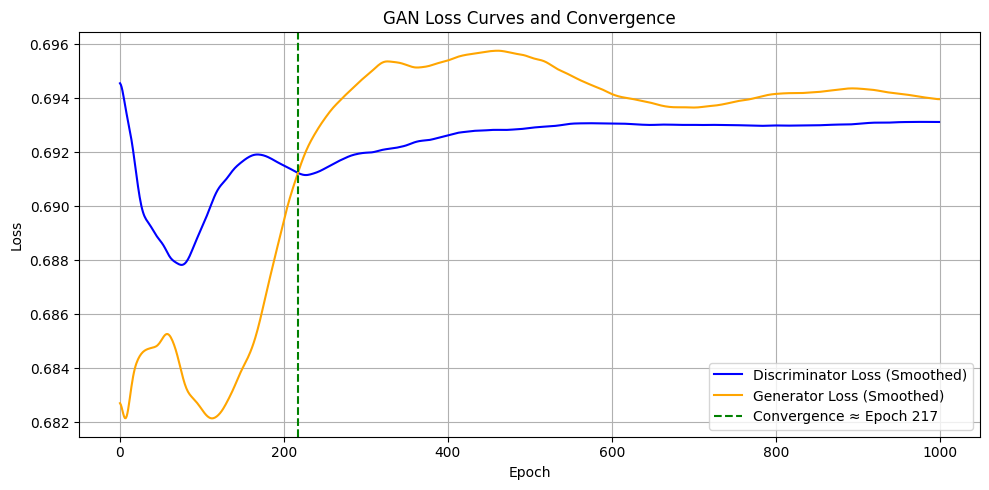

In [ ]:

# 📈 Step 6: Plot smoothed loss curves
d_losses_smooth = gaussian_filter1d(d_losses, sigma=5)
g_losses_smooth = gaussian_filter1d(g_losses, sigma=5)

plt.figure(figsize=(10, 5))
plt.plot(d_losses_smooth, label='Discriminator Loss (Smoothed)', color='blue')
plt.plot(g_losses_smooth, label='Generator Loss (Smoothed)', color='orange')
convergence_epoch = np.argmin(np.abs(np.array(d_losses_smooth) - np.array(g_losses_smooth)))
plt.axvline(convergence_epoch, color='green', linestyle='--', label=f'Convergence ≈ Epoch {convergence_epoch}')
plt.title('GAN Loss Curves and Convergence')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


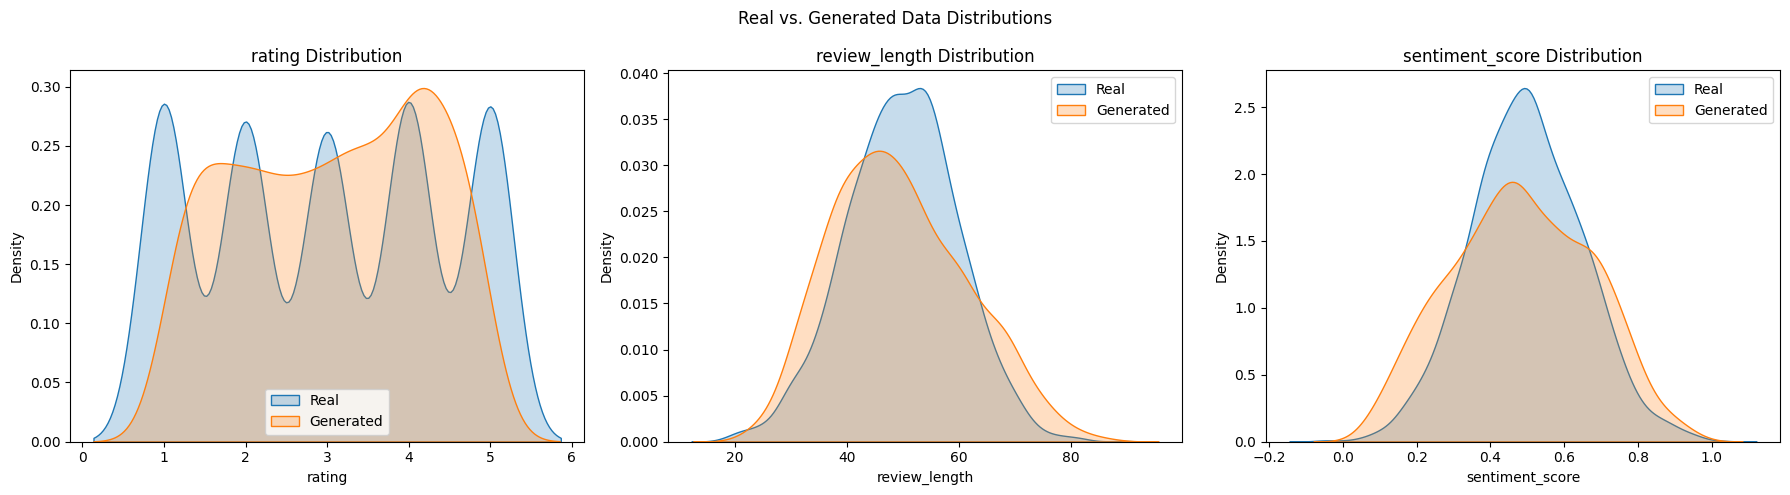

In [ ]:

# 📊 Step 7: Evaluate real vs. generated data distributions
noise = np.random.normal(0, 1, (1000, latent_dim))
synth_data = generator.predict(noise, verbose=0)
synth_df = pd.DataFrame(scaler.inverse_transform(synth_data), columns=df.columns)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, col in enumerate(df.columns):
    sns.kdeplot(df[col], label='Real', ax=axes[i], fill=True)
    sns.kdeplot(synth_df[col], label='Generated', ax=axes[i], fill=True)
    axes[i].set_title(f'{col} Distribution')
    axes[i].legend()
plt.suptitle("Real vs. Generated Data Distributions")
plt.tight_layout()
plt.show()
